# Parallel Plates Charge Measurement
## Importing data

In [1]:
import os, fnmatch, csv
import numpy as np

class Experiment(object):
    def __init__(self, data, name, start=0, end=-1, volume=1, voltage=1000, frame_rate=29.95, \
                 outlier=False, time=60, threeD=False, charge=1E-11, u0=1):
        self.data = data
        self.name = name
        self.start = start
        self.end = end
        self.volume = volume
        self.voltage = voltage
        self.frame_rate = frame_rate
        self.outlier = outlier
        self.time = time
        self.threeD = threeD
        self.charge = charge
        self.u0 = u0

def import_data(exp_class):
    """
    Takes an experiment type and returns an array of Experiment class objects, with attributes specified by
    a metadata csv. The 'data' attribute The column heads include:
    'R','Area','XM','YM','Major','Minor','Angle','Circ','Slice','AR','Round','Solidity'
    """
    meta_file_location = '../data/' + exp_class + '/meta2.csv'
    datatype = ('U9', int, int, float, float, float, bool, float)
    metadata = np.genfromtxt(meta_file_location, delimiter=',', dtype=datatype, names=True)
    globals()[exp_class + '_data_list'] = np.array([])
    for drop in metadata:
        name = 'drop' + str(drop['name'])
        start = drop['start']
        end = drop['end']
        volume = drop['volume']
        voltage = drop['voltage']
        frame_rate = drop['frame_rate']
        outlier = drop['outlier']
        time = drop['time']
        path = '../data/' + exp_class + '/' + str(drop['name']) + '.csv'
        data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
        globals()['drop' + str(drop['name'])] = Experiment(data, name, start, end, volume, voltage, \
                                                           frame_rate, outlier, time)
        globals()[exp_class + '_data_list'] = np.append(globals()[exp_class + '_data_list'], \
                                                        globals()['drop' + str(drop['name'])])

In [2]:
exp_class = 'parallel_plates'
import_data(exp_class)

# use fancy indexing to make a list of outliers
mask = [datas.outlier==False for datas in parallel_plates_data_list]
outliers = {datas.name:datas for datas in parallel_plates_data_list[mask]}
broken_mask = [datas.name!='drop05714' for datas in parallel_plates_data_list]
alldrops = {datas.name:datas for datas in parallel_plates_data_list[broken_mask]}

## Filtering

In [4]:
from scipy import signal
def sg_filter(y, dt):
    dtdt=dt*dt
    y_savgol = signal.savgol_filter(y, 25, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, 25, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, 25, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, 25, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol

#signal.savgol_filter?
# experiment with other modes than interp?

## Trajectory Plots

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_formats=['svg']
%matplotlib inline

def trajectory(dataset, component='XM'):
    #for key, val in dataset.items():
    tracking = dataset.data
    a = dataset.start
    b = dataset.end
    if component in dataset.data.dtype.names:
        trackdir = component
    else:
        print("Only valid arguments are 'x' and 'y'")
        raise
    
    try:
        t = tracking['Slice'][a:-b]/dataset.frame_rate
        x_points = tracking[trackdir][a:-b]
        x = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[0]
        dx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[1]
        ddx = sg_filter(tracking[trackdir][a:-b],t[1]-t[0])[2]
        derivs=[x,dx,ddx]
        return t, derivs, x_points
    except TypeError:
        print(dataset.name)

def plotter(dataset, raw=False, deriv=1, component='XM'):
    (t, derivs, x_points) = trajectory(dataset, component)
    if raw==True:
        plt.plot(t,x_points)
    else:
        plt.plot(t,derivs[deriv], label=dataset.name)
    

The error of a particular trajectory is probably the d(0.1*drop_radius)/dt

In [6]:
def plot_series(expgroup, raw=False, deriv=1, component='XM'):
    if raw==True and deriv !=0:
        raw = False
    for keys, vals in expgroup.items():
        plotter(vals, raw, deriv, component)
    #plt.ylim((-2,2))
    plt.xlim((0.1,2))
    plt.xlabel('t ($s$)')
    #plt.ylim((-1,.3))
    plt.ylabel(component)
    plt.legend(loc = 'best')
    plt.show()

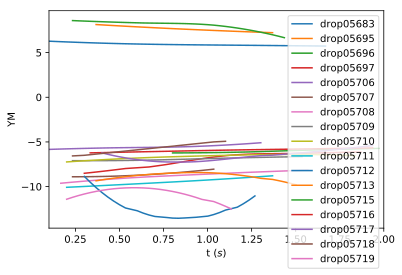

In [7]:
#dic = {'drop05719':drop05719,'drop05712':drop05712,'drop05713':drop05713,'drop05717':drop05717} # 'curvy' drops
#dic = {'drop05683':drop05683,'drop05695':drop05695,'drop05696':drop05696}
plot_series(alldrops, deriv=1, component='YM', raw=False)

## Data analysis and statistics

In [18]:
from scipy import optimize

def cubic_model(x,a,b,c):
    return a*x**2 + b*x + c

#def curve_fitting(dataset):
#    guess = [0,0,0]
#    (t, derivs, x_points) = trajectory(dataset)
#    params, params_covariance = optimize.curve_fit(cubic_model, derivs[0], t, guess)
#    return params

def curve_fitting(dataset, component='XM'):
    (t, derivs, x_points) = trajectory(dataset, component)
    params = np.polyfit(t, derivs[0], 2)
    return params

def mass_ammount(volume):
    """Takes volume in mL and converts to kg (for a given density, water)"""
    density = 1000
    return density*volume * 1E-6

def charge_ammount(val):
    d = 28.30/1000
    E = 2* val.voltage/d
    return (curve_fitting(val)[0]/100) * mass_ammount(val.volume)/E

def series_accelerations(expgroup):
    const_accel = []
    keys = []
    charge = []
    u0 = []
    for key, val in expgroup.items():
        const_accel.append(curve_fitting(val)[0])
        u0.append(curve_fitting(val, component='YM')[1])
        charge.append(charge_ammount(val))
        val.charge = charge[-1]
        val.u0 = u0[-1]
        keys.append(key)
        #print(key, curve_fitting(val)[0], charge[-1])
    #return np.vstack((np.array(keys).T, np.array(const_accel, dtype=float).T))
    return np.array(const_accel, dtype=float), np.array(charge, dtype=float)

In [19]:
print(series_accelerations(alldrops)[1])
print('avg. charge: ', np.mean(-np.absolute(series_accelerations(alldrops)[1])), 'C')
print('standard deviation: ', np.std(-np.absolute(series_accelerations(alldrops)[1])), 'C')
np.mean(-np.absolute(series_accelerations(alldrops)[1]))-np.std(-np.absolute(series_accelerations(alldrops)[1]))

[ -2.70158796e-12  -4.20176010e-12   7.78928795e-12  -4.86568450e-12
  -1.79171842e-12  -1.74111697e-11  -1.07898239e-11  -5.68331113e-12
  -2.89082418e-12  -2.57343722e-12  -1.30402067e-11  -7.51379045e-13
   1.11525974e-12  -9.83808965e-13  -6.00145897e-13  -2.84923705e-12
  -9.78463511e-12]
avg. charge:  -5.28372220811e-12 C
standard deviation:  4.7390711512e-12 C


-1.0022793359313684e-11

This charge seems much too high. Check units of charge function.
    $$ \frac{m d \mathbf{a}}{V} = q $$

In [10]:
import pandas

#for key, val in alldrops.items():
#    print(key, -np.absolute(val.u0))
charge = -1*np.absolute([data.charge for data in alldrops.values()])
volume = [data.volume for data in alldrops.values()]
data = pandas.DataFrame({'charge': charge, \
                  'volume': volume});


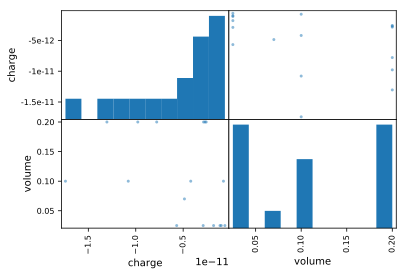

In [11]:
from pandas import plotting
plotting.scatter_matrix(data[['charge', 'volume']]);

In [12]:
from statsmodels.formula.api import ols, rlm
model = ols("charge ~ volume", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 charge   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.138
Date:                Tue, 18 Jul 2017   Prob (F-statistic):              0.164
Time:                        18:08:47   Log-Likelihood:                 420.29
No. Observations:                  17   AIC:                            -836.6
Df Residuals:                      15   BIC:                            -834.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.871e-12   2.01e-12     -1.430      0.1

/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


## Munging

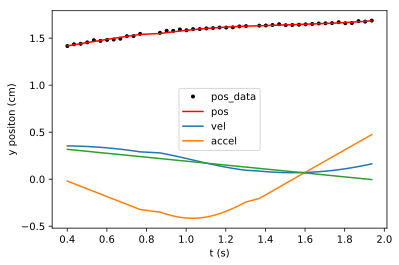

mean acceleration is -0.11 cm/s^2


In [13]:
"""Fine tuning to remove edge effects"""

k = drop05717
a=k.start
b=-k.end
t = k.data['Slice'][a:b]/k.frame_rate
x = k.data['XM'][a:b]
dt = t[1]-t[0]
plt.plot(t,x,'k.', t,sg_filter(x, dt)[0],'r', t, sg_filter(x, dt)[1], t, sg_filter(x, dt)[2])
plt.legend(['pos_data','pos','vel','accel'], loc='best')
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')
aa, bb, cc = (-0.10467562,  0.40118869,  1.28274475)
#plt.plot(t, cubic_model(t, aa,bb,cc))
plt.plot(t, np.ones(len(t))*aa*2*t+bb) # plot least squares velocity
plt.show()
print('mean acceleration is {:.2f} cm/s^2'.format(np.mean(sg_filter(x, dt)[2])))

### Shell script for editing metadata

In [14]:
header = {'name':1,'start':2,'end':3,'volume':4,'voltage':5,'frame_rate':6,'outlier':7,'time':8}
row = !grep -n "{k.name[4:]}" ../data/parallel_plates/meta2.csv | cut -d , -f 1 | cut -d : -f 1
row = int(row[0])
col = header['end']
value = 5

In [15]:
%%bash -s "$row" "$col" "$value"
#awk -v r=$1 -v c=$2 -v val=$3 -F, 'BEGIN{OFS=","}; NR != r; NR == r {$c = val; print}' \
#../data/parallel_plates/meta2.csv > ../data/parallel_plates/meta3.csv
#cp ../data/parallel_plates/meta3.csv ../data/parallel_plates/meta2.csv
#rm ../data/parallel_plates/meta3.csv
cat ../data/parallel_plates/meta2.csv

name,start,end,volume,voltage,frame_rate,outlier,time
05683,0,1,0.2,644,29.95,False,180
05695,1,1,0.1,644,29.95,False,127
05696,1,7,0.2,644,29.95,False,294
05697,0,1,0.07,644,29.95,False,304
05706,0,1,0.025,644,29.95,False,300
05707,1,10,0.1,634,29.95,False,130
05708,0,2,0.1,634,29.95,False,76
05709,0,2,0.025,634,29.95,False,72
05710,2,5,0.025,637,29.95,False,120
05711,0,1,0.2,628,29.95,False,62
05712,0,1,0.2,628,29.95,False,120
05713,4,5,0.1,621,29.95,False,60
05714,0,1,0.1,621,29.95,True,304
05715,4,9,0.025,621,29.95,False,60
05716,3,3,0.025,621,29.95,False,327
05717,0,9,0.025,617,29.95,False,122
05718,0,4,0.2,617,29.95,False,71
05719,0,5,0.2,617,29.95,False,300


### Notes
I need to manually remove some bad points and refilter. Some of those crazy curves are from end effects. If I see linear acceleration curves that may be due to image charges. For approximately constant curves, the average value should be used for the Coulombic force. Some of the acceleration is clearly due to camera shifts or bad thresholding. Use polynomial fit for the accleration and compare to the average value of the acceleration. Drops 05708, 05706, 05719 clearly has non-constant acceleration, this could also be due to drag (I should compare x-velocities for these drops to the mean of the population). If I knew approximately the d postion I could compare to the image charge, and plot q vs t ~ which should stay constant I'd suppose. Something wierd going on with drop 05717. Drop 05713 has issues.

Drop 05714 doesnt have matching column lengths.

Note that possibly one of the drops has the wrong $dt$

Should I compare with smoothing splines here?

Out of 18 drops, 12 had constant acceleration.
Make a dictionary of removed points a,b: call them in the plot loop for acclerations, remove those points pre-smoothing.

Why would only some of the droplets have noticible forces due to image charges? Bifurcation?

### More notes
- drop05696, drop05715 is constant, but in the opposite of the expected direction
- drop05708 might not be constant
- drop05713, drop5718 close to zero acceleration